In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle

In [12]:
data = pd.read_csv('Churn_Modelling.csv').dropna()

Подключаем датасет, убираем пропуски

In [13]:
df = data.drop(columns = ['Surname','RowNumber','CustomerId'], axis = 1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Убираем ненужные столбцы - фамилии нам не нужны, так как у нас есть просто построчный счет, интесы строк тоже не нужны, мы оставили счет строк. Уникальный идентификатор клиента тоже не нужен, так как у нас есть индексирование строк

In [14]:
category = ['Geography', 'Gender'] 
encoder = OrdinalEncoder()
df[category] = encoder.fit_transform(df[category])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  float64
 2   Gender           10000 non-null  float64
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 859.5 KB


Приводим категориальные признаки к числовому формату. 

In [15]:
target = df['Exited']
features = df.drop('Exited', axis = 1)

Формируем целевой показатель и матрицу признаков

In [16]:
class_zero = target[target==0].count()
class_one = target[target==1].count()
print('Соотношение классов', class_one/class_zero)

Соотношение классов 0.25580811252040686


У нас есть определенный дисбаланс классов, 75% на 25% превосходит 0 класс, нам стоит учесть это, когда мы будем делить на тестовую и обучающую выборки.

In [17]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

Делим  выборку - 80 на 20, не забываем учесть дисбаланс и стратифицировать выборки

In [18]:
category_1 = [ 'CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary' ]
scaler = StandardScaler()
features_train[category_1] = scaler.fit_transform(features_train[category_1])
features_test[category_1] = scaler.transform(features_test[category_1])

Масштабируем числовые признаки - не все, так как некоторые признаки итак бинарные.

In [19]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
predictions = model.predict(features_test)

#выведем метрику модели
print("\033[1mF1 на тестовой выборке:\033[0m", f1_score(target_test, predictions))

F1 на тестовой выборке: 0.22924901185770752


Проводим обучение и тест на не до конца подготовленных данны с дисбалансом. Получаем плохой результат.

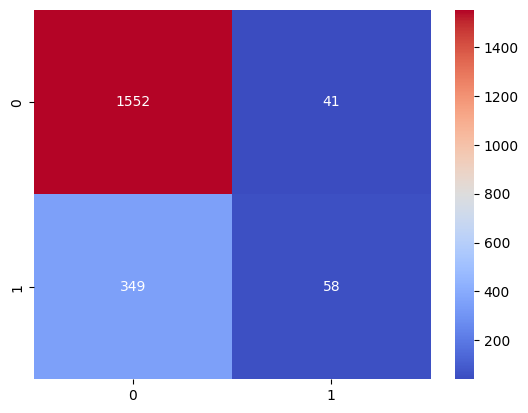

In [20]:
sb.heatmap(confusion_matrix(target_test, predictions), 
           annot=True, fmt=".10g", cmap= 'coolwarm')
plt.show()

Как мы можем увидеть, у нас очень много истинно отрицательных предсказаний, так как выборки содержат больше 0-класса, однако истинно положительных предсказаний не так уж и много.

In [21]:
def downsample(features, target, random_state):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    n_ones = len(features_ones)
    features_zeros_downsampled = features_zeros.sample(n=n_ones, random_state=random_state)
    target_zeros_downsampled = target_zeros.sample(n=n_ones, random_state=random_state)
    
    # Объединяем
    features_downsampled = pd.concat([features_zeros_downsampled, features_ones])
    target_downsampled = pd.concat([target_zeros_downsampled, target_ones])
    
    # Перемешиваем
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=random_state
    )
    
    return features_downsampled, target_downsampled

Далее я создаем функцию, которая будет уменьшать класс с отрицательными значениями (пробовал сделать наоборот, но так получилось лучше, думаю из-за того, что даных стало поменьше)

In [22]:
features_upsampled, target_upsampled = downsample(features_train, target_train, 2)

# обучим модель, построим прогноз на тестовой выборке
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)

#выведем метрику модели
print("\033[1mF1 на тестовой выборке:\033[0m", f1_score(target_test, predictions))

F1 на тестовой выборке: 0.5021496130696474


Переобучаем машину на других выборках и получаем ответ, который по заданию нас впринципе удовлетворяет F1 > 0.5

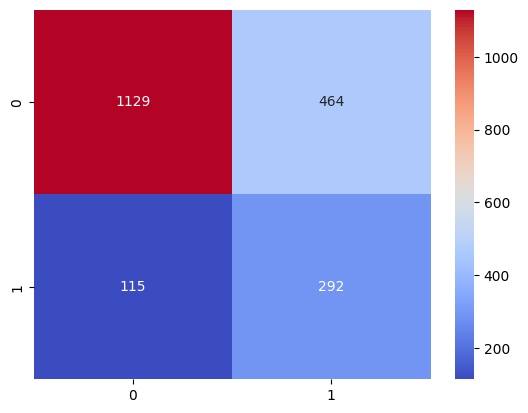

In [23]:
sb.heatmap(confusion_matrix(target_test, predictions), 
           annot=True, fmt=".10g", cmap= 'coolwarm')
plt.show()

Как мы видим, машина уже намного лучше стала предсказывать истинно положительные результаты, чего мы и ожидали.

# Выводы
### В дааной работе мы увидили, что обработка данных, масштабирование признаков и изменения выборки может очень серьезно повлиять на данные.  